<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/KFold_%22LM%2C_Ridge%2C_DT%2C_RF%2C_XGB%2Bneer_cpi_2002_2019%2001.02.2021%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [882]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

!pip install pmdarima -q
#from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima


In [883]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

# **Переменные**

In [884]:
cpi = "year"
reg_names = ['NVS']
data_do = "2019-12-01"
train_do = "2019-06-01"

result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'method', 'rmse'])
#result_rmse.append(cpi, reg_names, data_do, train_do, 'method', 'rmse')

In [885]:
data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)
data.isna().sum().sum()

0

In [886]:
data.tail(12)

,RF,BEL,BRY,VLA,VOR,IVA,KAL,KOS,KUR,LIP,MOS,ORL,RYA,SMO,TAM,TVE,TUL,YAR,MOW,KAR,KOM,ARK,VLG,KAG,LEN,MUR,NGR,PSK,SPB,ADY,KLM,KRA,AST,VGG,ROS,DAG,ING,KAB,KAO,NOR,STA,BAS,MAR,MOR,TAT,UDM,CHV,PER,KIR,NIZ,ORE,PNZ,SAM,SAR,ULY,KUG,SVE,TYU,CHE,ALI,TUV,KHK,ALT,KYA,IRK,KEM,NVS,OMS,TOM,BUR,ZAB,SAH,KAM,PRI,KHA,AMU,MAG,SAK,JEW,CHU
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-01,103.40,102.67,103.38,103.09,103.36,103.60,102.96,104.14,104.06,103.48,103.71,103.47,102.94,102.29,104.30,102.94,102.47,104.32,103.85,103.34,103.61,103.17,103.04,103.35,103.13,103.98,103.26,102.37,103.12,101.94,104.04,103.09,103.09,102.65,102.91,103.98,103.79,104.17,102.46,102.77,103.70,103.41,103.36,102.26,102.99,102.57,102.47,103.30,102.72,103.41,103.17,102.73,103.35,102.92,103.20,104.22,103.42,102.22,103.33,101.30,103.18,103.83,103.29,103.49,104.30,103.68,102.69,103.57,103.65,104.56,104.11,103.24,103.78,102.97,103.80,105.08,102.37,103.92,105.24,105.06
2019-12-01,102.80,102.33,102.93,101.79,102.34,102.84,102.10,103.48,103.18,102.59,102.90,103.02,101.63,101.51,103.59,102.05,101.76,103.07,103.42,102.60,102.58,102.41,102.61,102.43,102.34,103.19,102.61,101.59,102.55,101.72,103.11,102.34,102.40,102.23,101.99,103.48,103.78,103.42,101.77,101.68,102.77,102.56,102.16,101.72,102.50,102.14,101.65,102.87,102.41,102.62,102.19,102.11,102.63,102.38,102.61,103.35,102.74,102.17,102.94,101.65,102.96,103.13,102.90,103.24,103.90,103.17,101.94,103.08,102.96,103.75,103.84,103.12,103.34,102.94,103.50,105.10,102.16,103.98,104.85,104.78
2020-01-01,102.29,101.66,101.85,101.70,101.84,102.32,101.36,103.08,102.75,102.29,102.13,102.04,101.50,100.93,102.77,101.43,101.06,102.49,102.81,102.16,102.06,102.00,102.26,101.89,102.06,102.88,102.30,101.03,101.95,101.76,102.53,101.86,101.83,101.59,101.68,103.33,103.75,103.01,101.57,101.50,102.32,101.93,101.78,101.12,101.97,101.61,101.58,102.21,102.68,102.41,101.73,101.47,101.89,101.81,101.93,102.81,101.88,101.77,102.59,101.88,102.73,102.61,102.32,102.72,103.79,101.96,101.75,102.40,102.51,103.76,103.65,102.68,103.00,102.89,103.54,105.12,102.10,104.13,104.96,103.42
2020-02-01,102.05,101.60,101.87,101.57,101.78,102.29,101.65,102.98,102.73,102.04,101.83,101.82,101.39,100.94,102.43,101.43,101.19,102.21,102.34,102.20,102.45,102.05,102.14,102.00,101.95,102.57,102.18,100.68,101.65,101.78,101.85,101.67,101.38,101.55,101.71,103.14,103.53,103.01,101.32,100.50,102.59,101.65,101.90,101.04,101.89,101.55,101.17,102.44,102.41,101.68,101.48,101.22,102.18,101.95,101.98,102.52,101.39,101.48,102.21,101.37,102.39,101.93,102.25,102.40,103.25,101.47,101.21,102.14,102.20,103.17,103.17,102.86,102.58,102.96,103.56,105.08,102.95,103.78,104.57,101.66
2020-03-01,102.39,101.86,102.67,102.04,102.58,103.08,101.98,103.60,102.86,102.21,101.90,102.45,101.95,101.61,102.73,101.90,102.08,103.11,102.36,102.63,102.51,102.38,103.07,102.40,102.32,102.96,102.81,101.48,102.23,101.85,102.39,101.96,101.91,102.19,101.87,103.34,103.14,103.25,102.00,101.18,102.93,102.49,102.20,101.79,101.96,102.07,101.49,102.65,103.06,102.37,101.92,102.13,102.28,102.70,102.40,102.96,101.94,101.85,102.87,101.27,102.93,102.13,102.56,102.39,103.34,101.94,101.73,102.42,102.19,103.24,103.74,102.80,102.09,102.64,103.35,105.09,103.65,103.84,104.76,101.05
2020-04-01,103.18,102.77,103.43,102.96,103.73,103.92,103.38,103.94,103.89,103.13,102.63,103.48,103.45,103.39,104.27,103.11,103.32,103.48,102.59,103.38,103.23,103.36,103.72,103.06,103.12,103.88,103.62,102.27,102.87,102.49,103.86,102.85,102.97,103.32,102.82,104.87,104.41,104.33,102.51,102.49,103.34,103.73,103.25,102.49,102.71,102.57,102.89,103.52,104.16,103.43,102.76,103.49,102.97,103.99,103.21,103.90,103.16,102.59,103.72,102.78,103.70,103.38,103.18,103.04,104.06,102.64,102.82,103.06,103.19,103.94,104.71,102.89,102.53,103.71,104.62,105.79,104.02,104.18,106.08,101.33
2020-05-01,103.07,102.95,103.74,102.52,103.67,103.54,103.51,103.79,103.66,103.14,102.80,103.49,103.61,102.99,103.82,103.11,103.24,103.68,102.65,103.46,103.25,103.36,103.

# **Проверка на стационарность**

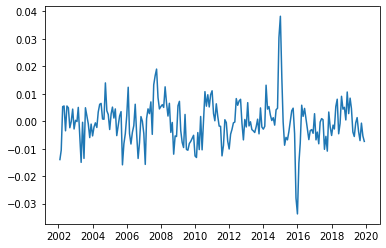

In [887]:
# to log  and diff
data_st = pd.DataFrame(index = data.index[1:])
#data_st = pd.DataFrame(index = data.index)

for region in data.columns:
#  data_st[region] = np.log(data[region].values)
  data_st[region] = np.diff(np.log(data[region].values))
data_st=(data_st[:-10])

plt.plot(data_st[reg_names])

In [888]:
"""
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
st = 0
notst = 0
p_value = 0.01
for num, region in enumerate(data_st.keys()):
  if region == 'RF':
    continue
  adf_result = adfuller(data_st[region])
  result_text = []
  result_text.append('ADF: {:.5}, '.format(adf_result[0]))
  result_text.append('p-val: {:.2}, '.format(adf_result[1]))
  if adf_result[1] < float(p_value):
      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      st += 1
  else:
      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      notst += 1
print('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)
"""

"\nfrom statsmodels.tsa.stattools import adfuller\n%matplotlib inline\nst = 0\nnotst = 0\np_value = 0.01\nfor num, region in enumerate(data_st.keys()):\n  if region == 'RF':\n    continue\n  adf_result = adfuller(data_st[region])\n  result_text = []\n  result_text.append('ADF: {:.5}, '.format(adf_result[0]))\n  result_text.append('p-val: {:.2}, '.format(adf_result[1]))\n  if adf_result[1] < float(p_value):\n      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))\n      st += 1\n  else:\n      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))\n      notst += 1\nprint('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)\n"

In [889]:
#if use stationary data
#data=data_st
"""
# для стационарных рядов
data_st = data_st[reg_names]
data_st = data_st[:data_do]
data_st = data_st.merge(course_m, left_on='date', right_on='date')
data_st['month'] = pd.DatetimeIndex(data_st.index).month
train_st = data_st[data_st.index < train_do]
test_st = data_st[data_st.index >= train_do]
"""
# for ML
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')
data['month'] = pd.DatetimeIndex(data.index).month

train = data[data.index < train_do]
test = data[data.index >= train_do]


# **ARIMA**

In [890]:
exogenous_features = ['month', 'curs']

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=721.660, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=552.850, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=653.183, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=510.005, Time=0.42 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=582.854, Time=0.30 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=512.003, Time=0.60 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=512.003, Time=0.64 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=528.967, Time=0.50 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=513.893, Time=1.84 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=511.983, Time=1.02 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
T

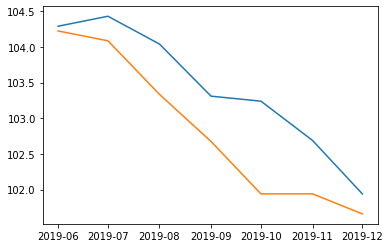

In [891]:
  # find best params for ARIMA
  stepwise_model = auto_arima (train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, 
                               D=1, d=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

"""  stepwise_model = auto_arima(train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True, \
                              d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, \
                              out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'oob')
  
stepwise_model = auto_arima(train_data['cpi_sfo'], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True,
                           d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
"""

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))


In [892]:
result = pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMA'])
result

,ARIMA
date,
2019-06-01,104.224112
2019-07-01,104.086007
2019-08-01,103.335181
2019-09-01,102.675045
2019-10-01,101.940499
2019-11-01,101.941604
2019-12-01,101.660090


In [893]:
#result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'method', 'rmse'])

result_arima = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ARIMA', 'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arima, ignore_index = True) 

In [894]:
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764


# **ARIMAX**

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=722.977, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=552.971, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=656.181, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=508.703, Time=1.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=575.971, Time=0.79 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=510.701, Time=1.67 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=510.701, Time=1.76 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=525.487, Time=1.24 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=512.637, Time=4.32 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=510.684, Time=1.72 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
T

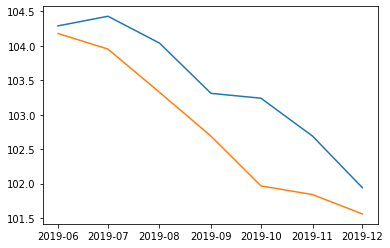

In [895]:
# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], start_p=1, start_q=1, 
                            max_p=4, max_q=4, m=12, start_P=0, seasonal=True,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [896]:
result['ARIMAX']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMAX'])

In [897]:
result

,ARIMA,ARIMAX
date,,
2019-06-01,104.224112,104.179688
2019-07-01,104.086007,103.953446
2019-08-01,103.335181,103.325782
2019-09-01,102.675045,102.688024
2019-10-01,101.940499,101.966695
2019-11-01,101.941604,101.840468
2019-12-01,101.660090,101.559682


In [898]:
result_arimax = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ARIMAX', 
                'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arimax, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512


# **Feature Engineering**

In [899]:
data_lags = pd.DataFrame()

data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values
for i in {1, 6, 12}:
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values
    
data_lags.index = data.index
data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags

,curs,t,t-1,t-12,t-6,month
date,,,,,,
2003-01-01,31.816165,110.41,110.37,111.19,109.92,1
2003-02-01,31.698979,110.40,110.41,109.65,110.46,2
2003-03-01,31.453290,110.96,110.40,108.50,110.20,3
2003-04-01,31.211786,110.40,110.96,109.08,110.19,4
2003-05-01,30.907055,108.76,110.40,109.69,110.68,5
...,...,...,...,...,...,...
2019-08-01,65.587483,104.04,104.43,101.56,104.85,8
2019-09-01,64.958705,103.31,104.04,102.01,105.34,9
2019-10-01,64.374991,103.24,103.31,102.53,104.93,10


In [900]:
df=data_lags
df.reset_index(drop=False, inplace=True)
lag_features = ["t", "curs"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("date", drop=True, inplace=True)
df.head(12)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,curs,t,t-1,t-12,t-6,month,t_mean_lag3,t_mean_lag6,t_mean_lag12,t_std_lag3,t_std_lag6,t_std_lag12,curs_mean_lag3,curs_mean_lag6,curs_mean_lag12,curs_std_lag3,curs_std_lag6,curs_std_lag12
date,,,,,,,,,,,,,,,,,,
2003-01-01,31.816165,110.41,110.37,111.19,109.92,1,107.403191,107.454636,107.537231,0.608752,1.009354,1.663820,39.286484,39.042568,38.549793,0.986750,1.496779,2.150076
2003-02-01,31.698979,110.40,110.41,109.65,110.46,2,110.410004,110.410004,110.410004,0.608752,1.009354,1.663820,31.816166,31.816166,31.816166,0.986750,1.496779,2.150076
2003-03-01,31.453290,110.96,110.40,108.50,110.20,3,110.404999,110.404999,110.404999,0.007071,0.007071,0.007071,31.757572,31.757572,31.757572,0.082863,0.082863,0.082863
2003-04-01,31.211786,110.40,110.96,109.08,110.19,4,110.589996,110.589996,110.589996,0.320468,0.320468,0.320468,31.656145,31.656145,31.656145,0.185191,0.185191,0.185191
2003-05-01,30.907055,108.76,110.40,109.69,110.68,5,110.586670,110.542503,110.542503,0.323316,0.278373,0.278373,31.454685,31.545055,31.545055,0.243599,0.268751,0.268751
2003-06-01,30.468626,108.72,108.76,109.31,110.37,6,110.040001,110.185997,110.185997,1.143328,0.832815,0.832815,31.190710,31.417456,31.417456,0.273727,0.368211,0.368211
2003-07-01,30.360287,107.26,108.72,109.92,110.41,7,109.293335,109.941666,109.941666,0.958610,0.955540,0.955540,30.862490,31.259317,31.259317,0.373579,0.508438,0.508438
2003-08-01,30.349027,107.79,107.26,110.46,110.40,8,108.246666,109.416664,109.558571,0.854712,1.405954,1.337241,30.578655,31.016670,31.130884,0.289515,0.536183,0.575230
2003-09-01,30.598633,108.01,107.79,110.20,110.96,9,107.923332,108.981667,109.337502,0.739076,1.444111,1.386988,30.392647,30.791679,31.033152,0.066041,0.472003,0.600027


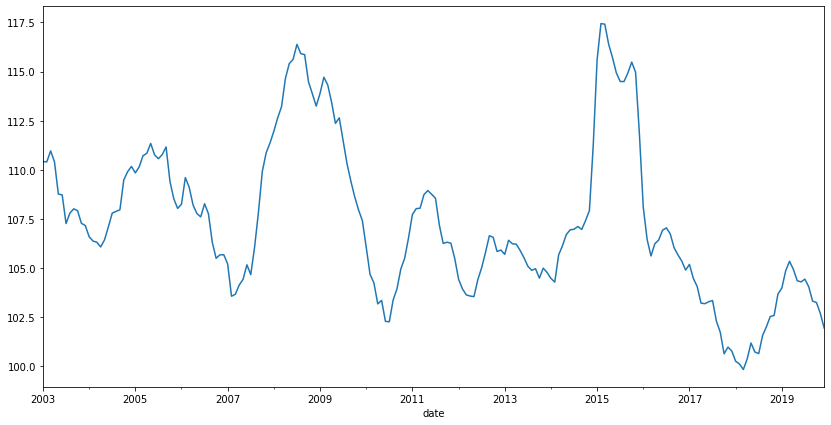

In [901]:
df.t.plot(figsize=(14, 7))

In [902]:
data = df
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

"""
X_train = train.values
y_train = train[['t']].values.ravel()
X_test = test.values
y_test = test[['t']].values.ravel()
"""
X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()


In [903]:
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])
result

,ARIMA,ARIMAX,y_test
date,,,
2019-06-01,104.224112,104.179688,104.29
2019-07-01,104.086007,103.953446,104.43
2019-08-01,103.335181,103.325782,104.04
2019-09-01,102.675045,102.688024,103.31
2019-10-01,101.940499,101.966695,103.24
2019-11-01,101.941604,101.840468,102.69
2019-12-01,101.660090,101.559682,101.94


# **KNeighborsRegressor**

In [904]:
!pip install mglearn -q

In [905]:
from sklearn.datasets import make_blobs
import mglearn
from sklearn.neighbors import KNeighborsRegressor

# instantiate the model 
KNmodel = KNeighborsRegressor(n_neighbors=5)
# fit the model using the training data and training targets
KNmodel.fit(X_train, y_train)

print("Training set score: {:.2f}".format(KNmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNmodel.score(X_test, y_test)))

forecast = KNmodel.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: -0.13
rmse: 0.8927
normed rmse: 0.8631%


In [906]:
result['KNR']=pd.DataFrame(np.array(forecast), index = test.index, columns=['KNR'])

In [907]:
result

,ARIMA,ARIMAX,y_test,KNR
date,,,,
2019-06-01,104.224112,104.179688,104.29,104.688
2019-07-01,104.086007,103.953446,104.43,104.410
2019-08-01,103.335181,103.325782,104.04,104.410
2019-09-01,102.675045,102.688024,103.31,104.176
2019-10-01,101.940499,101.966695,103.24,104.176
2019-11-01,101.941604,101.840468,102.69,103.614
2019-12-01,101.660090,101.559682,101.94,103.614


In [908]:
result_KNR = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'KNR', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_KNR, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653


# **OLS**

In [909]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

forecast = lr.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.73
rmse: 0.4336
normed rmse: 0.4192%


In [910]:
result['OLS']=pd.DataFrame(np.array(forecast), index = test.index, columns=['OLS'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS
date,,,,,
2019-06-01,104.224112,104.179688,104.29,104.688,103.815217
2019-07-01,104.086007,103.953446,104.43,104.410,104.149595
2019-08-01,103.335181,103.325782,104.04,104.410,104.558704
2019-09-01,102.675045,102.688024,103.31,104.176,103.746450
2019-10-01,101.940499,101.966695,103.24,104.176,102.728912
2019-11-01,101.941604,101.840468,102.69,103.614,102.942599
2019-12-01,101.660090,101.559682,101.94,103.614,102.416744


In [911]:
result_OLS = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'OLS', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_OLS, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572


# **Ridge (l2-regularisation)**

In [912]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

forecast = ridge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.76
rmse: 0.41155
normed rmse: 0.40%


In [913]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

forecast = ridge10.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.81
rmse: 0.36942
normed rmse: 0.36%


In [914]:
ridge01 = Ridge(alpha=0.001).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

forecast = ridge01.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97318
Test set score: 0.73
rmse: 0.43354
normed rmse: 0.42%


In [915]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge
date,,,,,,
2019-06-01,104.224112,104.179688,104.29,104.688,103.815217,103.815263
2019-07-01,104.086007,103.953446,104.43,104.410,104.149595,104.149503
2019-08-01,103.335181,103.325782,104.04,104.410,104.558704,104.558622
2019-09-01,102.675045,102.688024,103.31,104.176,103.746450,103.746520
2019-10-01,101.940499,101.966695,103.24,104.176,102.728912,102.729025
2019-11-01,101.941604,101.840468,102.69,103.614,102.942599,102.942565
2019-12-01,101.660090,101.559682,101.94,103.614,102.416744,102.416696


In [916]:
result_Ridge = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'Ridge', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Ridge, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539


# **Lasso (l1-regularisation)**

In [917]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

forecast = lasso.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.95
Test set score: 0.61
Number of features used: 2
rmse: 0.5244
normed rmse: 0.51%


In [918]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.80
Number of features used: 14
rmse: 0.37963
normed rmse: 0.37%


In [919]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso
date,,,,,,,
2019-06-01,104.224112,104.179688,104.29,104.688,103.815217,103.815263,103.906793
2019-07-01,104.086007,103.953446,104.43,104.410,104.149595,104.149503,104.005040
2019-08-01,103.335181,103.325782,104.04,104.410,104.558704,104.558622,104.376672
2019-09-01,102.675045,102.688024,103.31,104.176,103.746450,103.746520,103.843186
2019-10-01,101.940499,101.966695,103.24,104.176,102.728912,102.729025,102.936757
2019-11-01,101.941604,101.840468,102.69,103.614,102.942599,102.942565,102.906420
2019-12-01,101.660090,101.559682,101.94,103.614,102.416744,102.416696,102.320749


In [920]:
result_Lasso = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'Lasso', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Lasso, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539
5,year,[NVS],2019-12-01,2019-06-01,Lasso,0.379631


# **ElasticNet (l1+l2-regularisation)**

In [921]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.1, max_iter=100000).fit(X_train, y_train)

print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.83
Number of features used: 12
rmse: 0.34287
normed rmse: 0.33%


In [922]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet
date,,,,,,,,
2019-06-01,104.224112,104.179688,104.29,104.688,103.815217,103.815263,103.906793,104.151872
2019-07-01,104.086007,103.953446,104.43,104.410,104.149595,104.149503,104.005040,104.059303
2019-08-01,103.335181,103.325782,104.04,104.410,104.558704,104.558622,104.376672,104.307154
2019-09-01,102.675045,102.688024,103.31,104.176,103.746450,103.746520,103.843186,103.903939
2019-10-01,101.940499,101.966695,103.24,104.176,102.728912,102.729025,102.936757,103.119063
2019-11-01,101.941604,101.840468,102.69,103.614,102.942599,102.942565,102.906420,102.930024
2019-12-01,101.660090,101.559682,101.94,103.614,102.416744,102.416696,102.320749,102.352365


In [923]:
result_ElasticNet = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ElasticNet', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_ElasticNet, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539
5,year,[NVS],2019-12-01,2019-06-01,Lasso,0.379631
6,year,[NVS],2019-12-01,2019-06-01,ElasticNet,0.342869


# **DecisionTree**

In [924]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

forecast = tree.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

result['DecisionTree']=pd.DataFrame(np.array(forecast), index = test.index, columns=['DecisionTree'])
result

result_DT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'DT', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_DT, ignore_index = True) 
result_rmse

Accuracy on training set: 0.982
Accuracy on test set: -0.094
rmse: 0.87753
normed rmse: 0.85%


,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539
5,year,[NVS],2019-12-01,2019-06-01,Lasso,0.379631
6,year,[NVS],2019-12-01,2019-06-01,ElasticNet,0.342869
7,year,[NVS],2019-12-01,2019-06-01,DT,0.877533


# **GridSearch DecisionTree**

In [ ]:
param_grid = {'max_depth': [1, 2, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 50, 100],
              'max_leaf_nodes': [10, 20, 30, 500, 1000]}
print("Parameter grid:\n{}".format(param_grid))

GSDT = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=12)
GSDT.fit(X_train, y_train)

print("Test set score: {:.2f}".format(GSDT.score(X_test, y_test)))
print("Best parameters: {}".format(GSDT.best_params_))
print("Best estimator:\n{}".format(GSDT.best_estimator_))

# make predictions
GSDT_forecast = GSDT.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSDT_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSDT_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSDT_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSDT.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSDT.score(X_test, y_test)))

result['GSDT']=pd.DataFrame(np.array(GSDT_forecast), index = test.index, columns=['GSDT'])

result_GSDT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'GSDT', 
                'rmse': mean_squared_error(y_test, GSDT_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSDT, ignore_index = True) 
result_rmse

# **Random Forest**

rmse: 0.84964
normed rmse: 0.822%
Accuracy on training set: 0.993
Accuracy on test set: -0.025


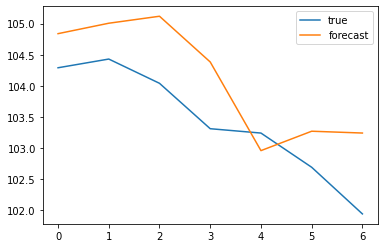

In [926]:
from sklearn.ensemble import RandomForestRegressor

RFmodel = RandomForestRegressor(n_estimators=500, random_state=42)
RFmodel.fit(X_train, y_train)
forecast = RFmodel.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.3f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(RFmodel.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(RFmodel.score(X_test, y_test)))

In [927]:
result['Random Forest']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Random Forest'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree,GSDT,Random Forest
date,,,,,,,,,,,
2019-06-01,104.224112,104.179688,104.29,104.688,103.815217,103.815263,103.906793,104.151872,105.330000,104.316739,104.83834
2019-07-01,104.086007,103.953446,104.43,104.410,104.149595,104.149503,104.005040,104.059303,105.330000,104.316739,105.00602
2019-08-01,103.335181,103.325782,104.04,104.410,104.558704,104.558622,104.376672,104.307154,105.330000,104.316739,105.11832
2019-09-01,102.675045,102.688024,103.31,104.176,103.746450,103.746520,103.843186,103.903939,103.956923,104.316739,104.38294
2019-10-01,101.940499,101.966695,103.24,104.176,102.728912,102.729025,102.936757,103.119063,103.057143,104.316739,102.95764
2019-11-01,101.941604,101.840468,102.69,103.614,102.942599,102.942565,102.906420,102.930024,103.057143,104.316739,103.26960
2019-12-01,101.660090,101.559682,101.94,103.614,102.416744,102.416696,102.320749,102.352365,103.057143,104.316739,103.24042


In [928]:
result_RF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RF', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RF, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539
5,year,[NVS],2019-12-01,2019-06-01,Lasso,0.379631
6,year,[NVS],2019-12-01,2019-06-01,ElasticNet,0.342869
7,year,[NVS],2019-12-01,2019-06-01,DT,0.877533
8,year,[NVS],2019-12-01,2019-06-01,GSDT,1.228134
9,year,[NVS],2019-12-01,2019-06-01,RF,0.849639


In [929]:
RFmodel.feature_importances_

array([0.00175233, 0.94340316, 0.00732804, 0.00352083, 0.00265703,
       0.00536456, 0.00175973, 0.00279121, 0.00260774, 0.00363814,
       0.00884053, 0.00163127, 0.00182993, 0.00249169, 0.00318848,
       0.00348436, 0.00371095])

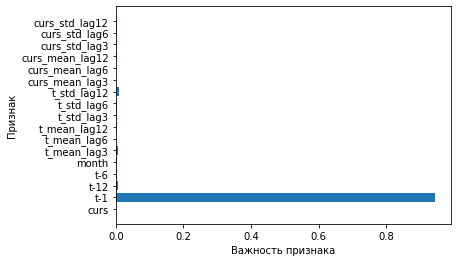

In [930]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(RFmodel)

# **GSRF**

Parameter grid:
{'n_estimators': [1, 10, 50, 100, 200, 300]}
Test set score: 0.02
Best parameters: {'n_estimators': 100}
Best estimator:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rmse: 0.8324
normed rmse: 0.8049%
Accuracy on training set: 0.993
Accuracy on test set: 0.016


,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539
5,year,[NVS],2019-12-01,2019-06-01,Lasso,0.379631
6,year,[NVS],2019-12-01,2019-06-01,ElasticNet,0.342869
7,year,[NVS],2019-12-01,2019-06-01,DT,0.877533
8,year,[NVS],2019-12-01,2019-06-01,GSDT,1.228134
9,year,[NVS],2019-12-01,2019-06-01,RF,0.849639


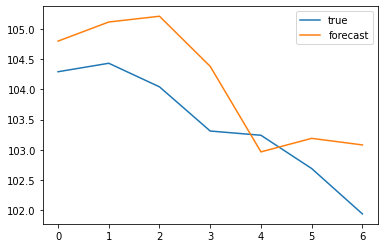

In [931]:
param_grid = {'n_estimators': [1, 10, 50, 100, 200, 300]}
print("Parameter grid:\n{}".format(param_grid))

GSRF = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
GSRF.fit(X_train, y_train)

print("Test set score: {:.2f}".format(GSRF.score(X_test, y_test)))
print("Best parameters: {}".format(GSRF.best_params_))
print("Best estimator:\n{}".format(GSRF.best_estimator_))

# make predictions
GSRF_forecast = GSRF.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSRF_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSRF_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSRF_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSRF.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSRF.score(X_test, y_test)))

result['GSRF']=pd.DataFrame(np.array(GSRF_forecast), index = test.index, columns=['GSRF'])

result_GSRF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'GSRF', 
                'rmse': mean_squared_error(y_test, GSRF_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSRF, ignore_index = True) 
result_rmse

# **Кроссвалидация**

In [932]:
"""
from sklearn.model_selection import cross_val_score

scores = cross_val_score(GSRF, X_train, y_train, cv=3)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

from sklearn.model_selection import cross_validate
res = cross_validate(GSRF, X_train, y_train, cv=4,
                     return_train_score=True)
display(res)

res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

"""

'\nfrom sklearn.model_selection import cross_val_score\n\nscores = cross_val_score(GSRF, X_train, y_train, cv=3)\nprint("Cross-validation scores: {}".format(scores))\nprint("Average cross-validation score: {:.2f}".format(scores.mean()))\n\nfrom sklearn.model_selection import cross_validate\nres = cross_validate(GSRF, X_train, y_train, cv=4,\n                     return_train_score=True)\ndisplay(res)\n\nres_df = pd.DataFrame(res)\ndisplay(res_df)\nprint("Mean times and scores:\n", res_df.mean())\n\n'

# **Slide test**

In [933]:
"""
from datetime import datetime
from dateutil.relativedelta import relativedelta
#startdate = pd.to_datetime(data_do)
startdate = pd.to_datetime(train_do)+ relativedelta(months=1)

#print('Today: ', startdate.strftime('%Y-%m-%d'))
#print(date_after_month.strftime('%Y-%m-%d'))
#startdate = str(startdate)[:10]
startdate
"""

"\nfrom datetime import datetime\nfrom dateutil.relativedelta import relativedelta\n#startdate = pd.to_datetime(data_do)\nstartdate = pd.to_datetime(train_do)+ relativedelta(months=1)\n\n#print('Today: ', startdate.strftime('%Y-%m-%d'))\n#print(date_after_month.strftime('%Y-%m-%d'))\n#startdate = str(startdate)[:10]\nstartdate\n"

In [934]:
"""
#forecast = RFmodel.predict(X_test)
#slide_test = test[test.index == train_do][data_not.columns.values].values
#print(slide_test)
slide_test = X_test
forecast = []
forecast.append(RFmodel.predict(slide_test)[0])

for i in range(test.shape[0] - 1):
  
  slide_test_next = slide_test.copy()
  slide_test_next[0, 1] = forecast[-1]

  slide_test_next[0, 0] += 1
  slide_test_next[0, 2:] = slide_test[0, 1:-1]
  
  #print(slide_test_next)
  slide_test = slide_test_next.copy()

  forecast.append(RFmodel.predict(slide_test)[0])

forecast = np.array(forecast)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))
"""

"\n#forecast = RFmodel.predict(X_test)\n#slide_test = test[test.index == train_do][data_not.columns.values].values\n#print(slide_test)\nslide_test = X_test\nforecast = []\nforecast.append(RFmodel.predict(slide_test)[0])\n\nfor i in range(test.shape[0] - 1):\n  \n  slide_test_next = slide_test.copy()\n  slide_test_next[0, 1] = forecast[-1]\n\n  slide_test_next[0, 0] += 1\n  slide_test_next[0, 2:] = slide_test[0, 1:-1]\n  \n  #print(slide_test_next)\n  slide_test = slide_test_next.copy()\n\n  forecast.append(RFmodel.predict(slide_test)[0])\n\nforecast = np.array(forecast)\n\nplt.plot(y_test, label='true')\nplt.plot(forecast, label='forecast')\nplt.legend()\n\nprint('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))\nprint('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))\n"

In [935]:
"""result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RFST, ignore_index = True) 
result_rmse
"""

"result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', \n                'rmse': mean_squared_error(y_test, forecast) ** 0.5} \nresult_rmse = result_rmse.append(result_RFST, ignore_index = True) \nresult_rmse\n"

# **KFold cross validation**

In [936]:
"""
#!pip install mglearn -q
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import mglearn

%%time
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1)
#model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

print("Average cross-validation score: {:.2f}".format(scores.mean()))
"""


'\n#!pip install mglearn -q\nfrom sklearn.datasets import make_blobs\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.model_selection import cross_val_score\n\nimport mglearn\n\n%%time\nmodel = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1)\n#model.fit(X_train, y_train)\n\nscores = cross_val_score(model, X_train, y_train, cv=5)\nprint("Cross-validation scores: {}".format(scores))\n\nprint("Average cross-validation score: {:.2f}".format(scores.mean()))\n'

# **Stratified K-Fold cross-validation and other strategies**

In [937]:
"""
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)

print("Cross-validation scores:\n{}".format(
      cross_val_score(model, X_train, y_train, cv=kfold)))

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
print("Cross-validation scores:\n{}".format(
    cross_val_score(model, X_train, y_train, cv=kfold)))
"""

'\nfrom sklearn.model_selection import KFold\nkfold = KFold(n_splits=3)\n\nprint("Cross-validation scores:\n{}".format(\n      cross_val_score(model, X_train, y_train, cv=kfold)))\n\nkfold = KFold(n_splits=3, shuffle=True, random_state=42)\nprint("Cross-validation scores:\n{}".format(\n    cross_val_score(model, X_train, y_train, cv=kfold)))\n'

# **GradientBoostingRegressor**

In [938]:
from xgboost import XGBRegressor

rmse: 0.3773
normed rmse: 0.3648%
Accuracy on training set: 0.954
Accuracy on test set: 0.798


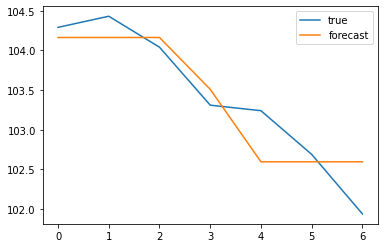

In [939]:
xgb_model = XGBRegressor (objective ='reg:squarederror', n_estimators=50, max_depth=3)
xgb_model.fit(X_train, y_train, verbose=False)
# make predictions
xgb_forecast = xgb_model.predict(X_test)
xgb_model.feature_importances_
plt.plot(y_test, label='true')
plt.plot(xgb_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, xgb_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, xgb_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_model.score(X_test, y_test)))

In [940]:
result['GradientBoosting']=pd.DataFrame(np.array(xgb_forecast), index = test.index, columns=['GradientBoosting'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree,GSDT,Random Forest,GSRF,GradientBoosting
date,,,,,,,,,,,,,
2019-06-01,104.224112,104.179688,104.29,104.688,103.815217,103.815263,103.906793,104.151872,105.330000,104.316739,104.83834,104.7962,104.162560
2019-07-01,104.086007,103.953446,104.43,104.410,104.149595,104.149503,104.005040,104.059303,105.330000,104.316739,105.00602,105.1120,104.162560
2019-08-01,103.335181,103.325782,104.04,104.410,104.558704,104.558622,104.376672,104.307154,105.330000,104.316739,105.11832,105.2072,104.162560
2019-09-01,102.675045,102.688024,103.31,104.176,103.746450,103.746520,103.843186,103.903939,103.956923,104.316739,104.38294,104.3786,103.509476
2019-10-01,101.940499,101.966695,103.24,104.176,102.728912,102.729025,102.936757,103.119063,103.057143,104.316739,102.95764,102.9653,102.596336
2019-11-01,101.941604,101.840468,102.69,103.614,102.942599,102.942565,102.906420,102.930024,103.057143,104.316739,103.26960,103.1890,102.596336
2019-12-01,101.660090,101.559682,101.94,103.614,102.416744,102.416696,102.320749,102.352365,103.057143,104.316739,103.24042,103.0803,102.596336


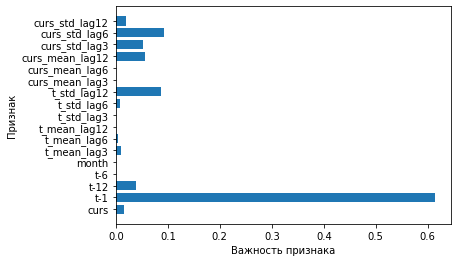

In [941]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(xgb_model)

In [942]:
result_XGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'XGB', 
                'rmse': mean_squared_error(y_test, xgb_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_XGB, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539
5,year,[NVS],2019-12-01,2019-06-01,Lasso,0.379631
6,year,[NVS],2019-12-01,2019-06-01,ElasticNet,0.342869
7,year,[NVS],2019-12-01,2019-06-01,DT,0.877533
8,year,[NVS],2019-12-01,2019-06-01,GSDT,1.228134
9,year,[NVS],2019-12-01,2019-06-01,RF,0.849639


# **Grid Search XGB**

Parameter grid:
{'max_depth': [1, 2, 3, 5], 'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
Test set score: 0.63
Best parameters: {'max_depth': 2, 'n_estimators': 300}
Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
rmse: 0.5074
normed rmse: 0.4906%
Accuracy on training set: 0.998
Accuracy on test set: 0.634


,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539
5,year,[NVS],2019-12-01,2019-06-01,Lasso,0.379631
6,year,[NVS],2019-12-01,2019-06-01,ElasticNet,0.342869
7,year,[NVS],2019-12-01,2019-06-01,DT,0.877533
8,year,[NVS],2019-12-01,2019-06-01,GSDT,1.228134
9,year,[NVS],2019-12-01,2019-06-01,RF,0.849639


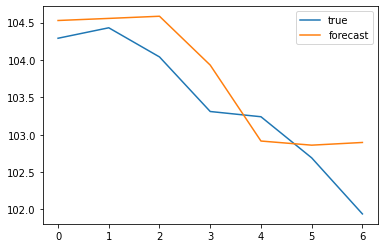

In [950]:
param_grid = {'max_depth': [1, 2, 3, 5],
              'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
print("Parameter grid:\n{}".format(param_grid))

GSXGB = GridSearchCV(XGBRegressor(objective ='reg:squarederror'), param_grid, cv=30)
GSXGB.fit(X_train, y_train, verbose=False)

print("Test set score: {:.2f}".format(GSXGB.score(X_test, y_test)))
print("Best parameters: {}".format(GSXGB.best_params_))
print("Best estimator:\n{}".format(GSXGB.best_estimator_))

# make predictions
GSXGB_forecast = GSXGB.predict(X_test)
plt.plot(y_test, label='true')
plt.plot(GSXGB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSXGB_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSXGB_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSXGB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSXGB.score(X_test, y_test)))

result['GridSearchXGB']=pd.DataFrame(np.array(GSXGB_forecast), index = test.index, columns=['GridSearchXGB'])

result_GSXGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'GridSearchXGB', 
                'rmse': mean_squared_error(y_test, GSXGB_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSXGB, ignore_index = True) 
result_rmse

# **Results**

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2019-06-01,ARIMA,0.691764
1,year,[NVS],2019-12-01,2019-06-01,ARIMAX,0.719512
2,year,[NVS],2019-12-01,2019-06-01,KNR,0.892653
3,year,[NVS],2019-12-01,2019-06-01,OLS,0.433572
4,year,[NVS],2019-12-01,2019-06-01,Ridge,0.433539
5,year,[NVS],2019-12-01,2019-06-01,Lasso,0.379631
6,year,[NVS],2019-12-01,2019-06-01,ElasticNet,0.342869
7,year,[NVS],2019-12-01,2019-06-01,DT,0.877533
8,year,[NVS],2019-12-01,2019-06-01,GSDT,1.228134
9,year,[NVS],2019-12-01,2019-06-01,RF,0.849639


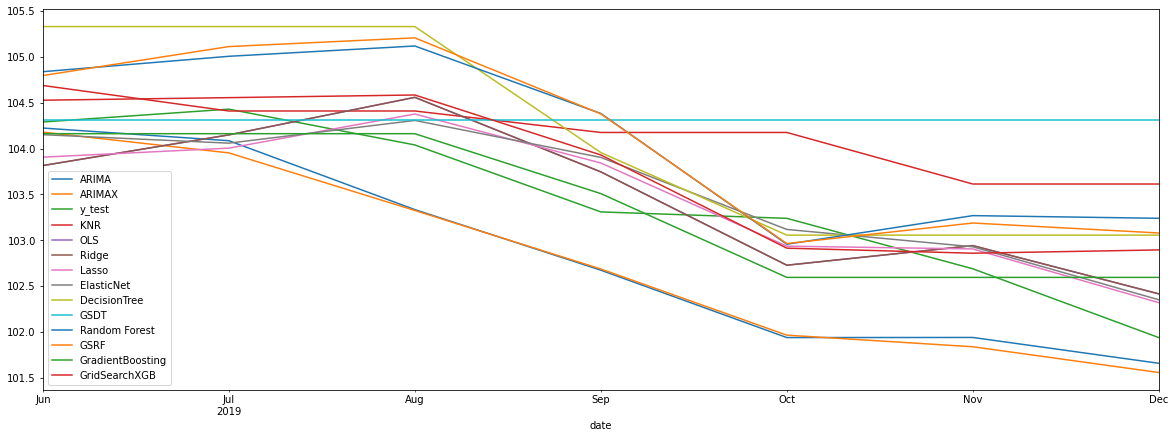

In [951]:
result.plot(figsize=(20, 7))
result_rmse